In [ ]:
EPOCHS = 30


In [ ]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [ ]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [ ]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [ ]:
BATCH_SIZE = 8
image_size = 224
num_workers = 4
pin_memory = torch.cuda.is_available()


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])


In [ ]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [ ]:
train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from timm.models.vision_transformer import VisionTransformer


class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained MobileNetV2
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half of MobileNetV2
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2 into blocks
        self.mobilenet_feature_blocks_1 = nn.Sequential(
            *pretrained_model.features[:num_blocks1 - 3]
        )
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels   # 160
        ch_mid = self.mobilenet_block_mid.out_channels             # 320
        ch_last = self.mobilenet_block_last.out_channels           # 1280
        ch_concat = ch_last + ch_2nd_last                           # 1440

        # CNN → ViT adapter
        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(ch_mid, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        # ViT encoder 1 (56×56 with overlapping patches)
        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        # Change stride for overlapping patches
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )

        # Recalculate number of patches
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)

        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        # ViT encoder 2 (28×28)
        self.vit_encoder2 = VisionTransformer(
            img_size=28,
            patch_size=7,
            in_chans=32,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        # CNN parallel head
        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )

        # Final classifier (binary when num_classes=2)
        self.classifier_head = nn.Linear(64 + 64 + 128, num_classes)

    def forward(self, x):
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        concatenated_cnn_features = torch.cat(
            [features_last, features_2nd_last], dim=1
        )

        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_features1 = self.vit_encoder1(x)
        vit_features2 = self.vit_encoder2(intermediate)

        cnn_features = self.cnn_parallel_head(concatenated_cnn_features)

        combined = torch.cat(
            [vit_features1, vit_features2, cnn_features], dim=1
        )

        return self.classifier_head(combined)


In [ ]:
model = CNN_ViT_Model(num_classes=2)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"]
)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

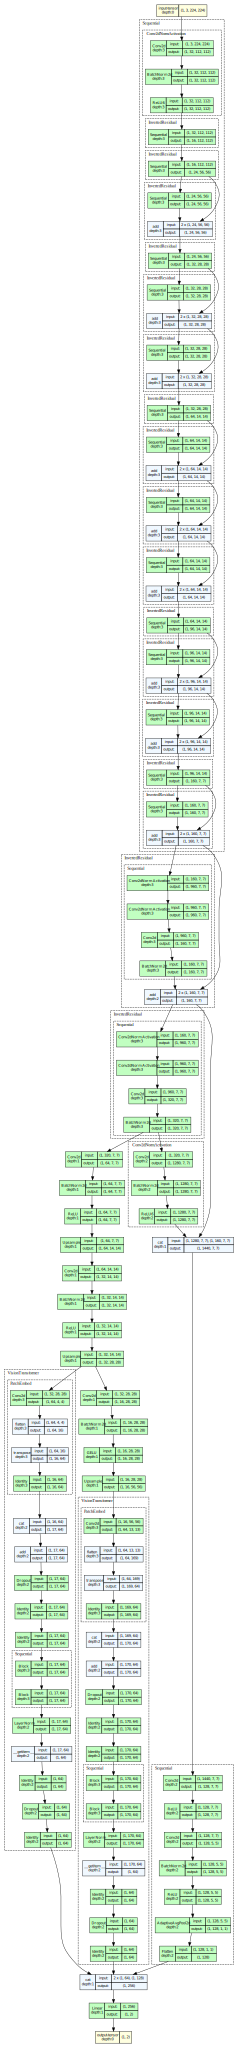

In [ ]:
model.to(device)

# Dummy input
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False
)

# Render and display
svg_output = model_graph.visual_graph.pipe(format="svg")
display(SVG(svg_output))


In [ ]:
def custom_metrics(y_pred, y_true, loss):
    """
    y_pred : raw logits of shape (B, 2)
    y_true : ground truth labels (0 or 1)
    loss   : scalar loss value
    """

    # Predictions
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Move to CPU / numpy
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred_classes.detach().cpu().numpy()

    # ---- Core metrics ----
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, zero_division=0)
    mcc = matthews_corrcoef(y_true_np, y_pred_np)

    # ---- Confusion matrix ----
    cm = confusion_matrix(y_true_np, y_pred_np)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # ---- AUC (binary, correct way) ----
    # Convert logits → probability of positive class
    y_prob = torch.softmax(y_pred, dim=1)[:, 1].detach().cpu().numpy()

    try:
        auc = roc_auc_score(y_true_np, y_prob)
    except ValueError:
        auc = 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc,
    }

    return metrics


In [ ]:
# Hyperparameters
num_epochs       = 30
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
import cv2


In [ ]:
import time
import numpy as np
from datetime import timedelta
from tqdm import tqdm

# ---------------- METRICS SETUP ----------------
metric_names = [
    "loss", "accuracy", "precision", "recall", "f1_score",
    "specificity", "sensitivity", "mcc", "auc"
]

train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time = 0.0
total_validation_time = 0.0


# ---------------- TRAINING LOOP ----------------
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch + 1}/{num_epochs} =====")
    epoch_start_time = time.time()

    # -------- TRAIN --------
    model.train()
    total_train_loss = 0.0
    train_outputs = []
    train_targets = []

    for data, targets in tqdm(train_loader, desc="Training"):
        data = data.to(device)
        targets = targets.to(device).long()   # ✅ REQUIRED FOR CrossEntropy

        optimizer.zero_grad()
        outputs = model(data)                 # (B, 2)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_outputs.append(outputs.detach())
        train_targets.append(targets.detach())

    avg_train_loss = total_train_loss / len(train_loader)

    train_outputs = torch.cat(train_outputs, dim=0)
    train_targets = torch.cat(train_targets, dim=0)

    train_metrics = custom_metrics(
        train_outputs, train_targets, avg_train_loss
    )

    print("Train Metrics - " + ", ".join(
        f"{k}: {v:.4f}" for k, v in train_metrics.items()
    ))

    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])

    epoch_training_time = time.time() - epoch_start_time
    total_training_time += epoch_training_time


    # -------- VALIDATION --------
    model.eval()
    total_val_loss = 0.0
    val_outputs = []
    val_targets = []

    val_start_time = time.time()

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            targets = targets.to(device).long()   # ✅ REQUIRED

            outputs = model(data)
            loss = criterion(outputs, targets)

            total_val_loss += loss.item()
            val_outputs.append(outputs)
            val_targets.append(targets)

    avg_val_loss = total_val_loss / len(val_loader)

    val_outputs = torch.cat(val_outputs, dim=0)
    val_targets = torch.cat(val_targets, dim=0)

    val_metrics = custom_metrics(
        val_outputs, val_targets, avg_val_loss
    )

    print("Val Metrics   - " + ", ".join(
        f"{k}: {v:.4f}" for k, v in val_metrics.items()
    ))

    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])

    epoch_validation_time = time.time() - val_start_time
    total_validation_time += epoch_validation_time


    # -------- LR SCHEDULER --------
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch + 1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"LR: {current_lr:.6f}"
    )


# ---------------- TIME SUMMARY ----------------
print("\n===== TRAINING SUMMARY =====")
print(f"Total Training Time   : {timedelta(seconds=total_training_time)}")
print(f"Total Validation Time : {timedelta(seconds=total_validation_time)}")

avg_train_time = total_training_time / num_epochs
avg_val_time   = total_validation_time / num_epochs

print(f"Avg Train Time/Epoch  : {timedelta(seconds=avg_train_time)}")
print(f"Avg Val Time/Epoch    : {timedelta(seconds=avg_val_time)}")



===== Epoch 1/30 =====


Training: 100%|██████████| 2335/2335 [03:05<00:00, 12.60it/s]


Train Metrics - loss: 0.4008, accuracy: 0.8143, precision: 0.6359, recall: 0.4114, f1_score: 0.4996, specificity: 0.9315, sensitivity: 0.4114, mcc: 0.4060, auc: 0.8313


Validation: 100%|██████████| 501/501 [00:35<00:00, 13.99it/s]


Val Metrics   - loss: 0.3640, accuracy: 0.8401, precision: 0.7205, recall: 0.4745, f1_score: 0.5722, specificity: 0.9465, sensitivity: 0.4745, mcc: 0.4948, auc: 0.8658
Epoch 1/30 | Train Loss: 0.4008 | Val Loss: 0.3640 | LR: 0.000100

===== Epoch 2/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.44it/s]


Train Metrics - loss: 0.3574, accuracy: 0.8383, precision: 0.6902, recall: 0.5119, f1_score: 0.5878, specificity: 0.9332, sensitivity: 0.5119, mcc: 0.4984, auc: 0.8719


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.36it/s]


Val Metrics   - loss: 0.3684, accuracy: 0.8276, precision: 0.7154, recall: 0.3902, f1_score: 0.5050, specificity: 0.9549, sensitivity: 0.3902, mcc: 0.4391, auc: 0.8650
Epoch 2/30 | Train Loss: 0.3574 | Val Loss: 0.3684 | LR: 0.000100

===== Epoch 3/30 =====


Training: 100%|██████████| 2335/2335 [02:51<00:00, 13.62it/s]


Train Metrics - loss: 0.3158, accuracy: 0.8580, precision: 0.7249, recall: 0.5955, f1_score: 0.6539, specificity: 0.9343, sensitivity: 0.5955, mcc: 0.5699, auc: 0.9038


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.31it/s]


Val Metrics   - loss: 0.3747, accuracy: 0.8336, precision: 0.6947, recall: 0.4667, f1_score: 0.5584, specificity: 0.9403, sensitivity: 0.4667, mcc: 0.4745, auc: 0.8615
Epoch 3/30 | Train Loss: 0.3158 | Val Loss: 0.3747 | LR: 0.000100

===== Epoch 4/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.56it/s]


Train Metrics - loss: 0.2423, accuracy: 0.8957, precision: 0.7948, recall: 0.7236, f1_score: 0.7576, specificity: 0.9457, sensitivity: 0.7236, mcc: 0.6925, auc: 0.9455


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.39it/s]


Val Metrics   - loss: 0.4349, accuracy: 0.8194, precision: 0.6101, recall: 0.5499, f1_score: 0.5784, specificity: 0.8978, sensitivity: 0.5499, mcc: 0.4649, auc: 0.8460
Epoch 4/30 | Train Loss: 0.2423 | Val Loss: 0.4349 | LR: 0.000100

===== Epoch 5/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.48it/s]


Train Metrics - loss: 0.1692, accuracy: 0.9305, precision: 0.8591, recall: 0.8272, f1_score: 0.8429, specificity: 0.9605, sensitivity: 0.8272, mcc: 0.7985, auc: 0.9739


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.27it/s]


Val Metrics   - loss: 0.5461, accuracy: 0.8026, precision: 0.5618, recall: 0.5643, f1_score: 0.5631, specificity: 0.8720, sensitivity: 0.5643, mcc: 0.4356, auc: 0.8278
Epoch 5/30 | Train Loss: 0.1692 | Val Loss: 0.5461 | LR: 0.000100

===== Epoch 6/30 =====


Training: 100%|██████████| 2335/2335 [02:51<00:00, 13.58it/s]


Train Metrics - loss: 0.1214, accuracy: 0.9531, precision: 0.8991, recall: 0.8919, f1_score: 0.8955, specificity: 0.9709, sensitivity: 0.8919, mcc: 0.8653, auc: 0.9864


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.16it/s]


Val Metrics   - loss: 0.6017, accuracy: 0.8034, precision: 0.5740, recall: 0.4945, f1_score: 0.5313, specificity: 0.8933, sensitivity: 0.4945, mcc: 0.4096, auc: 0.8221
Epoch 6/30 | Train Loss: 0.1214 | Val Loss: 0.6017 | LR: 0.000100

===== Epoch 7/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.52it/s]


Train Metrics - loss: 0.0955, accuracy: 0.9639, precision: 0.9244, recall: 0.9147, f1_score: 0.9195, specificity: 0.9782, sensitivity: 0.9147, mcc: 0.8963, auc: 0.9914


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.27it/s]


Val Metrics   - loss: 0.6000, accuracy: 0.8186, precision: 0.6097, recall: 0.5421, f1_score: 0.5739, specificity: 0.8991, sensitivity: 0.5421, mcc: 0.4605, auc: 0.8378
Epoch 7/30 | Train Loss: 0.0955 | Val Loss: 0.6000 | LR: 0.000100

===== Epoch 8/30 =====


Training: 100%|██████████| 2335/2335 [02:56<00:00, 13.27it/s]


Train Metrics - loss: 0.0788, accuracy: 0.9715, precision: 0.9391, recall: 0.9339, f1_score: 0.9365, specificity: 0.9824, sensitivity: 0.9339, mcc: 0.9181, auc: 0.9940


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.26it/s]


Val Metrics   - loss: 0.6984, accuracy: 0.8136, precision: 0.6046, recall: 0.5000, f1_score: 0.5473, specificity: 0.9049, sensitivity: 0.5000, mcc: 0.4344, auc: 0.8186
Epoch 8/30 | Train Loss: 0.0788 | Val Loss: 0.6984 | LR: 0.000100

===== Epoch 9/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.49it/s]


Train Metrics - loss: 0.0768, accuracy: 0.9711, precision: 0.9419, recall: 0.9292, f1_score: 0.9355, specificity: 0.9833, sensitivity: 0.9292, mcc: 0.9170, auc: 0.9943


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.31it/s]


Val Metrics   - loss: 0.7339, accuracy: 0.8071, precision: 0.6035, recall: 0.4202, f1_score: 0.4954, specificity: 0.9197, sensitivity: 0.4202, mcc: 0.3904, auc: 0.7800
Epoch 9/30 | Train Loss: 0.0768 | Val Loss: 0.7339 | LR: 0.000100

===== Epoch 10/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.56it/s]


Train Metrics - loss: 0.0613, accuracy: 0.9772, precision: 0.9507, recall: 0.9482, f1_score: 0.9494, specificity: 0.9857, sensitivity: 0.9482, mcc: 0.9348, auc: 0.9965


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.44it/s]


Val Metrics   - loss: 0.7767, accuracy: 0.8039, precision: 0.5660, recall: 0.5565, f1_score: 0.5612, specificity: 0.8758, sensitivity: 0.5565, mcc: 0.4350, auc: 0.8188
Epoch 10/30 | Train Loss: 0.0613 | Val Loss: 0.7767 | LR: 0.000100

===== Epoch 11/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.43it/s]


Train Metrics - loss: 0.0592, accuracy: 0.9804, precision: 0.9600, recall: 0.9525, f1_score: 0.9562, specificity: 0.9885, sensitivity: 0.9525, mcc: 0.9436, auc: 0.9962


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.19it/s]


Val Metrics   - loss: 0.8061, accuracy: 0.8201, precision: 0.6104, recall: 0.5576, f1_score: 0.5829, specificity: 0.8965, sensitivity: 0.5576, mcc: 0.4693, auc: 0.8342
Epoch 11/30 | Train Loss: 0.0592 | Val Loss: 0.8061 | LR: 0.000097

===== Epoch 12/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.44it/s]


Train Metrics - loss: 0.0523, accuracy: 0.9806, precision: 0.9572, recall: 0.9565, f1_score: 0.9569, specificity: 0.9876, sensitivity: 0.9565, mcc: 0.9443, auc: 0.9975


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.27it/s]


Val Metrics   - loss: 0.8979, accuracy: 0.8174, precision: 0.6278, recall: 0.4656, f1_score: 0.5347, specificity: 0.9197, sensitivity: 0.4656, mcc: 0.4315, auc: 0.8101
Epoch 12/30 | Train Loss: 0.0523 | Val Loss: 0.8979 | LR: 0.000094

===== Epoch 13/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.50it/s]


Train Metrics - loss: 0.0507, accuracy: 0.9819, precision: 0.9620, recall: 0.9572, f1_score: 0.9596, specificity: 0.9890, sensitivity: 0.9572, mcc: 0.9479, auc: 0.9971


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.28it/s]


Val Metrics   - loss: 0.7896, accuracy: 0.8136, precision: 0.6063, recall: 0.4933, f1_score: 0.5440, specificity: 0.9068, sensitivity: 0.4933, mcc: 0.4320, auc: 0.8066
Epoch 13/30 | Train Loss: 0.0507 | Val Loss: 0.7896 | LR: 0.000091

===== Epoch 14/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.51it/s]


Train Metrics - loss: 0.0448, accuracy: 0.9842, precision: 0.9648, recall: 0.9648, f1_score: 0.9648, specificity: 0.9898, sensitivity: 0.9648, mcc: 0.9546, auc: 0.9979


Validation: 100%|██████████| 501/501 [00:36<00:00, 13.87it/s]


Val Metrics   - loss: 0.7943, accuracy: 0.8169, precision: 0.6490, recall: 0.4080, f1_score: 0.5010, specificity: 0.9358, sensitivity: 0.4080, mcc: 0.4120, auc: 0.8185
Epoch 14/30 | Train Loss: 0.0448 | Val Loss: 0.7943 | LR: 0.000089

===== Epoch 15/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.57it/s]


Train Metrics - loss: 0.0399, accuracy: 0.9859, precision: 0.9713, recall: 0.9660, f1_score: 0.9687, specificity: 0.9917, sensitivity: 0.9660, mcc: 0.9596, auc: 0.9983


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.25it/s]


Val Metrics   - loss: 0.8437, accuracy: 0.8136, precision: 0.5956, recall: 0.5388, f1_score: 0.5658, specificity: 0.8936, sensitivity: 0.5388, mcc: 0.4484, auc: 0.8298
Epoch 15/30 | Train Loss: 0.0399 | Val Loss: 0.8437 | LR: 0.000086

===== Epoch 16/30 =====


Training: 100%|██████████| 2335/2335 [02:51<00:00, 13.58it/s]


Train Metrics - loss: 0.0303, accuracy: 0.9898, precision: 0.9792, recall: 0.9753, f1_score: 0.9773, specificity: 0.9940, sensitivity: 0.9753, mcc: 0.9707, auc: 0.9990


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.42it/s]


Val Metrics   - loss: 0.9529, accuracy: 0.7959, precision: 0.5390, recall: 0.6519, f1_score: 0.5901, specificity: 0.8378, sensitivity: 0.6519, mcc: 0.4595, auc: 0.8280
Epoch 16/30 | Train Loss: 0.0303 | Val Loss: 0.9529 | LR: 0.000083

===== Epoch 17/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.51it/s]


Train Metrics - loss: 0.0308, accuracy: 0.9889, precision: 0.9748, recall: 0.9760, f1_score: 0.9754, specificity: 0.9927, sensitivity: 0.9760, mcc: 0.9683, auc: 0.9990


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.10it/s]


Val Metrics   - loss: 0.9398, accuracy: 0.8134, precision: 0.6018, recall: 0.5078, f1_score: 0.5508, specificity: 0.9023, sensitivity: 0.5078, mcc: 0.4366, auc: 0.8114
Epoch 17/30 | Train Loss: 0.0308 | Val Loss: 0.9398 | LR: 0.000081

===== Epoch 18/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.46it/s]


Train Metrics - loss: 0.0276, accuracy: 0.9903, precision: 0.9788, recall: 0.9781, f1_score: 0.9785, specificity: 0.9938, sensitivity: 0.9781, mcc: 0.9722, auc: 0.9991


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.42it/s]


Val Metrics   - loss: 0.9742, accuracy: 0.8016, precision: 0.5547, recall: 0.6075, f1_score: 0.5799, specificity: 0.8581, sensitivity: 0.6075, mcc: 0.4512, auc: 0.8225
Epoch 18/30 | Train Loss: 0.0276 | Val Loss: 0.9742 | LR: 0.000078

===== Epoch 19/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.53it/s]


Train Metrics - loss: 0.0244, accuracy: 0.9914, precision: 0.9794, recall: 0.9827, f1_score: 0.9810, specificity: 0.9940, sensitivity: 0.9827, mcc: 0.9755, auc: 0.9995


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.10it/s]


Val Metrics   - loss: 1.0048, accuracy: 0.8151, precision: 0.6052, recall: 0.5166, f1_score: 0.5574, specificity: 0.9020, sensitivity: 0.5166, mcc: 0.4437, auc: 0.8191
Epoch 19/30 | Train Loss: 0.0244 | Val Loss: 1.0048 | LR: 0.000076

===== Epoch 20/30 =====


Training: 100%|██████████| 2335/2335 [02:55<00:00, 13.31it/s]


Train Metrics - loss: 0.0260, accuracy: 0.9904, precision: 0.9782, recall: 0.9791, f1_score: 0.9786, specificity: 0.9936, sensitivity: 0.9791, mcc: 0.9724, auc: 0.9993


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.19it/s]


Val Metrics   - loss: 1.0336, accuracy: 0.8131, precision: 0.5962, recall: 0.5288, f1_score: 0.5605, specificity: 0.8958, sensitivity: 0.5288, mcc: 0.4437, auc: 0.8099
Epoch 20/30 | Train Loss: 0.0260 | Val Loss: 1.0336 | LR: 0.000074

===== Epoch 21/30 =====


Training: 100%|██████████| 2335/2335 [02:55<00:00, 13.33it/s]


Train Metrics - loss: 0.0199, accuracy: 0.9929, precision: 0.9845, recall: 0.9841, f1_score: 0.9843, specificity: 0.9955, sensitivity: 0.9841, mcc: 0.9798, auc: 0.9996


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.18it/s]


Val Metrics   - loss: 0.9866, accuracy: 0.8144, precision: 0.5975, recall: 0.5399, f1_score: 0.5673, specificity: 0.8942, sensitivity: 0.5399, mcc: 0.4504, auc: 0.8361
Epoch 21/30 | Train Loss: 0.0199 | Val Loss: 0.9866 | LR: 0.000072

===== Epoch 22/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.53it/s]


Train Metrics - loss: 0.0133, accuracy: 0.9955, precision: 0.9907, recall: 0.9893, f1_score: 0.9900, specificity: 0.9973, sensitivity: 0.9893, mcc: 0.9871, auc: 0.9998


Validation: 100%|██████████| 501/501 [00:35<00:00, 13.94it/s]


Val Metrics   - loss: 1.1003, accuracy: 0.8164, precision: 0.6275, recall: 0.4557, f1_score: 0.5279, specificity: 0.9213, sensitivity: 0.4557, mcc: 0.4257, auc: 0.8145
Epoch 22/30 | Train Loss: 0.0133 | Val Loss: 1.1003 | LR: 0.000069

===== Epoch 23/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.45it/s]


Train Metrics - loss: 0.0165, accuracy: 0.9948, precision: 0.9879, recall: 0.9888, f1_score: 0.9884, specificity: 0.9965, sensitivity: 0.9888, mcc: 0.9850, auc: 0.9997


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.36it/s]


Val Metrics   - loss: 1.0119, accuracy: 0.8209, precision: 0.6155, recall: 0.5466, f1_score: 0.5790, specificity: 0.9007, sensitivity: 0.5466, mcc: 0.4671, auc: 0.8295
Epoch 23/30 | Train Loss: 0.0165 | Val Loss: 1.0119 | LR: 0.000067

===== Epoch 24/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.54it/s]


Train Metrics - loss: 0.0162, accuracy: 0.9941, precision: 0.9867, recall: 0.9869, f1_score: 0.9868, specificity: 0.9961, sensitivity: 0.9869, mcc: 0.9830, auc: 0.9997


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.09it/s]


Val Metrics   - loss: 1.1399, accuracy: 0.8194, precision: 0.6535, recall: 0.4224, f1_score: 0.5131, specificity: 0.9349, sensitivity: 0.4224, mcc: 0.4231, auc: 0.8155
Epoch 24/30 | Train Loss: 0.0162 | Val Loss: 1.1399 | LR: 0.000065

===== Epoch 25/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.47it/s]


Train Metrics - loss: 0.0169, accuracy: 0.9934, precision: 0.9848, recall: 0.9857, f1_score: 0.9853, specificity: 0.9956, sensitivity: 0.9857, mcc: 0.9810, auc: 0.9997


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.23it/s]


Val Metrics   - loss: 0.9877, accuracy: 0.8136, precision: 0.5848, recall: 0.5965, f1_score: 0.5906, specificity: 0.8768, sensitivity: 0.5965, mcc: 0.4700, auc: 0.8411
Epoch 25/30 | Train Loss: 0.0169 | Val Loss: 0.9877 | LR: 0.000063

===== Epoch 26/30 =====


Training: 100%|██████████| 2335/2335 [02:52<00:00, 13.50it/s]


Train Metrics - loss: 0.0150, accuracy: 0.9947, precision: 0.9886, recall: 0.9879, f1_score: 0.9882, specificity: 0.9967, sensitivity: 0.9879, mcc: 0.9848, auc: 0.9996


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.37it/s]


Val Metrics   - loss: 1.0254, accuracy: 0.8214, precision: 0.6173, recall: 0.5455, f1_score: 0.5792, specificity: 0.9016, sensitivity: 0.5455, mcc: 0.4678, auc: 0.8422
Epoch 26/30 | Train Loss: 0.0150 | Val Loss: 1.0254 | LR: 0.000061

===== Epoch 27/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.48it/s]


Train Metrics - loss: 0.0097, accuracy: 0.9968, precision: 0.9933, recall: 0.9924, f1_score: 0.9929, specificity: 0.9981, sensitivity: 0.9924, mcc: 0.9908, auc: 0.9999


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.29it/s]


Val Metrics   - loss: 1.1494, accuracy: 0.8156, precision: 0.5979, recall: 0.5554, f1_score: 0.5759, specificity: 0.8913, sensitivity: 0.5554, mcc: 0.4588, auc: 0.8358
Epoch 27/30 | Train Loss: 0.0097 | Val Loss: 1.1494 | LR: 0.000060

===== Epoch 28/30 =====


Training: 100%|██████████| 2335/2335 [02:54<00:00, 13.41it/s]


Train Metrics - loss: 0.0121, accuracy: 0.9955, precision: 0.9896, recall: 0.9905, f1_score: 0.9900, specificity: 0.9970, sensitivity: 0.9905, mcc: 0.9871, auc: 0.9998


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.35it/s]


Val Metrics   - loss: 0.9662, accuracy: 0.8224, precision: 0.6204, recall: 0.5455, f1_score: 0.5805, specificity: 0.9029, sensitivity: 0.5455, mcc: 0.4700, auc: 0.8302
Epoch 28/30 | Train Loss: 0.0121 | Val Loss: 0.9662 | LR: 0.000058

===== Epoch 29/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.49it/s]


Train Metrics - loss: 0.0114, accuracy: 0.9965, precision: 0.9926, recall: 0.9917, f1_score: 0.9922, specificity: 0.9979, sensitivity: 0.9917, mcc: 0.9899, auc: 0.9998


Validation: 100%|██████████| 501/501 [00:34<00:00, 14.35it/s]


Val Metrics   - loss: 1.1195, accuracy: 0.8201, precision: 0.6081, recall: 0.5676, f1_score: 0.5872, specificity: 0.8936, sensitivity: 0.5676, mcc: 0.4728, auc: 0.8317
Epoch 29/30 | Train Loss: 0.0114 | Val Loss: 1.1195 | LR: 0.000056

===== Epoch 30/30 =====


Training: 100%|██████████| 2335/2335 [02:53<00:00, 13.46it/s]


Train Metrics - loss: 0.0120, accuracy: 0.9960, precision: 0.9914, recall: 0.9910, f1_score: 0.9912, specificity: 0.9975, sensitivity: 0.9910, mcc: 0.9886, auc: 0.9998


Validation: 100%|██████████| 501/501 [00:35<00:00, 14.19it/s]

Val Metrics   - loss: 1.3034, accuracy: 0.8264, precision: 0.6688, recall: 0.4545, f1_score: 0.5413, specificity: 0.9345, sensitivity: 0.4545, mcc: 0.4514, auc: 0.8302
Epoch 30/30 | Train Loss: 0.0120 | Val Loss: 1.3034 | LR: 0.000054

===== TRAINING SUMMARY =====
Total Training Time   : 1:26:48.500160
Total Validation Time : 0:17:36.118540
Avg Train Time/Epoch  : 0:02:53.616672
Avg Val Time/Epoch    : 0:00:35.203951


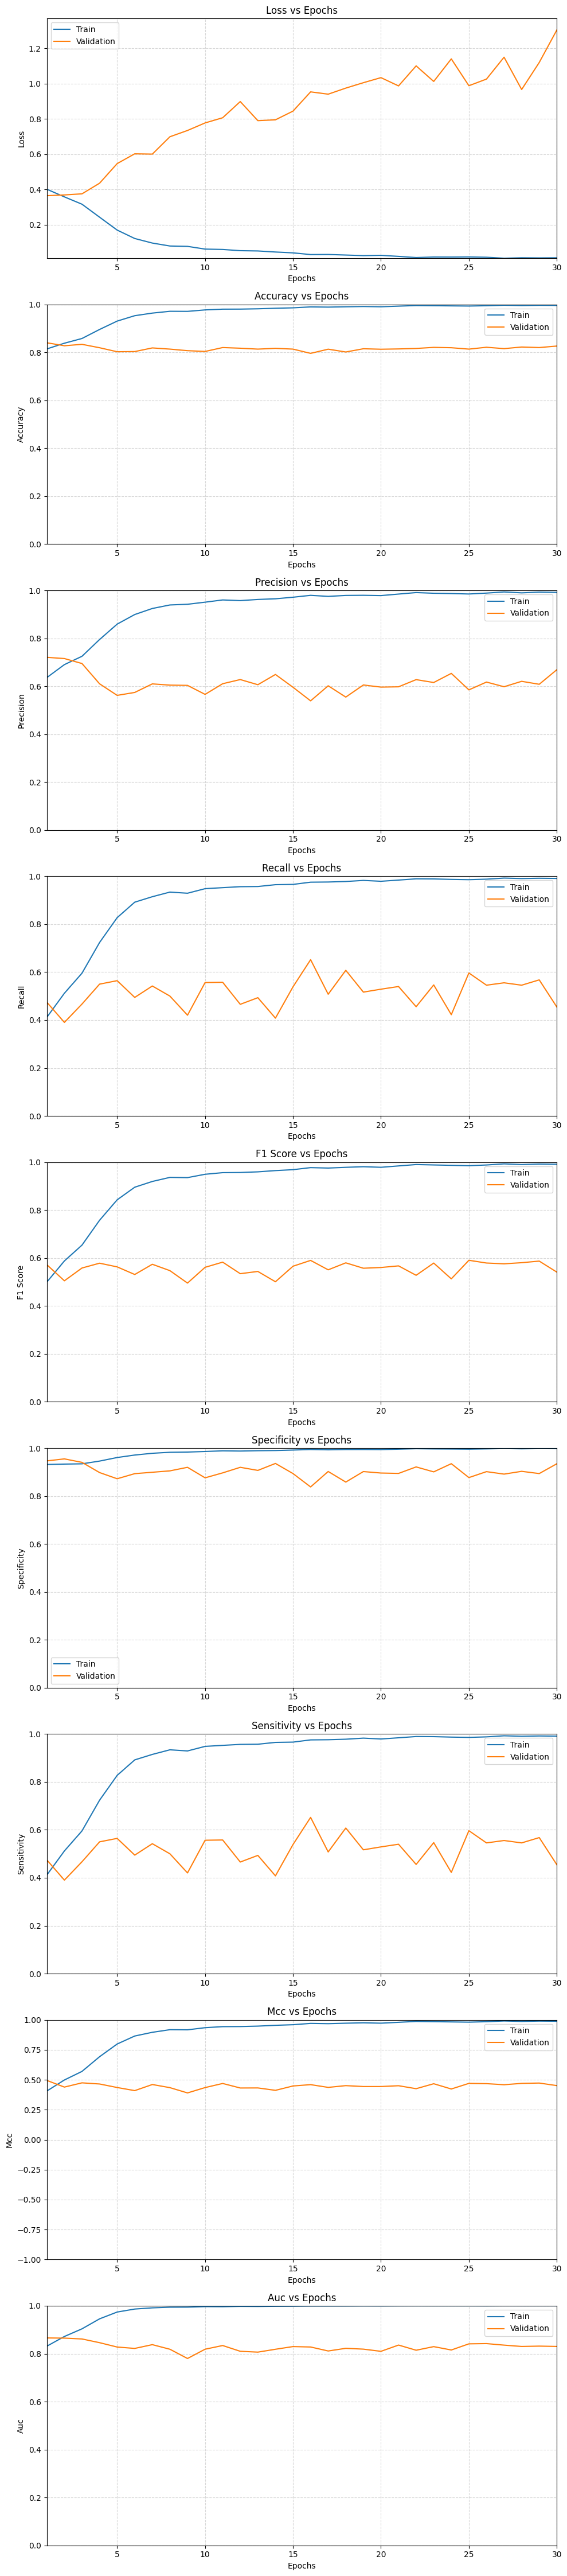

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    fig, axes = plt.subplots(num_metrics, figsize=(10, 5 * num_metrics))
    if num_metrics == 1:
        axes = [axes]

    epochs = range(1, num_epochs + 1)

    for ax, metric in zip(axes, metric_names):
        train_vals = train_metrics_history[metric]
        val_vals = val_metrics_history[metric]

        ax.plot(epochs, train_vals, label="Train")
        ax.plot(epochs, val_vals, label="Validation")
        ax.set_xlabel("Epochs")
        ax.legend()

        # ----- Titles & labels -----
        ax.set_title(f"{metric.replace('_', ' ').title()} vs Epochs")
        ax.set_ylabel(metric.replace('_', ' ').title())

        # ----- Y-axis scaling (correct & clean) -----
        if metric == "mcc":
            ax.set_ylim(-1.0, 1.0)
        elif metric in [
            "accuracy", "precision", "recall", "f1_score",
            "specificity", "sensitivity", "auc"
        ]:
            ax.set_ylim(0.0, 1.0)
        else:
            ymin = min(min(train_vals), min(val_vals))
            ymax = max(max(train_vals), max(val_vals))
            ax.set_ylim(ymin, ymax * 1.05)

        # ----- X-axis -----
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


# Call
plot_metrics(train_metrics_history, val_metrics_history, metric_names)


In [ ]:
# ---------------- TESTING LOOP ----------------
model.eval()
total_test_loss = 0.0
test_outputs = []
test_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data = data.to(device)
        targets = targets.to(device).long()   # ✅ REQUIRED for CrossEntropy

        outputs = model(data)                 # (B, 2)
        loss = criterion(outputs, targets)

        total_test_loss += loss.item()
        test_outputs.append(outputs)
        test_targets.append(targets)

# Aggregate
avg_test_loss = total_test_loss / len(test_loader)

test_outputs = torch.cat(test_outputs, dim=0)
test_targets = torch.cat(test_targets, dim=0)

# Metrics
test_metrics = custom_metrics(
    test_outputs, test_targets, avg_test_loss
)

print(
    "Test Metrics - " + ", ".join(
        f"{k}: {v:.4f}" for k, v in test_metrics.items()
    )
)


Testing Model: 100%|██████████| 501/501 [00:47<00:00, 10.52it/s]

Test Metrics - loss: 1.2023, accuracy: 0.8351, precision: 0.6845, recall: 0.4978, f1_score: 0.5764, specificity: 0.9332, sensitivity: 0.4978, mcc: 0.4865, auc: 0.8455


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# ---------------- PREPARE LABELS ----------------
# test_targets and test_outputs come from the corrected test loop

true_labels = test_targets.cpu().numpy()                    # shape (N,)
predicted_labels = torch.argmax(test_outputs, dim=1)        # shape (N,)
predicted_labels = predicted_labels.cpu().numpy()

# ---------------- CLASS NAMES ----------------
# Ensure correct order: index 0 → no pneumonia, index 1 → pneumonia
# Use your dataset class order
classes =  ['Normal', 'Pneumonia']

# Safety check
assert len(classes) == 2, "Binary classification must have exactly 2 classes"

# ---------------- CLASSIFICATION REPORT ----------------
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=classes,
    digits=4
)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy * 100:.2f}%"
)


              precision    recall  f1-score   support

      Normal     0.8647    0.9332    0.8976      3101
   Pneumonia     0.6845    0.4978    0.5764       902

    accuracy                         0.8351      4003
   macro avg     0.7746    0.7155    0.7370      4003
weighted avg     0.8240    0.8351    0.8253      4003

There were 660 errors in 4003 tests for an accuracy of 83.51%
